# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, **какой тариф приносит больше денег**.

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

🎯 Нужно проанализировать поведение клиентов и сделать вывод — **какой тариф лучше**.

## Changelog

- При слиянии датафреймов используется параметр `how='outer'` вместо `right` для того, чтобы получить записи по ключам из обоих датасетов;
- Дисперсия и другие метрики считаются не по агрегированным данным. Описание шага 3 ввело в заблуждение;
- Скорректированы выводы.

## Шаг 1. Откроем файлы с данными и изучим общую информацию

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

Для начала рассмотрим каждый из датасетов по отдельности. При необходимости будем соединять данные.

### Тарифы

In [3]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mg_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [4]:
'''
    Сразу же переименуем колонку с названием тарифа, чтобы в дальнейшем у нас была возможность применить merge по ней.
    Также исправим ошибку в названии признака объёма интернет-трафика.
'''
tariffs = tariffs.rename(columns={'tariff_name': 'tariff', 'mg_per_month_included': 'mb_per_month_included'})

In [5]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


С типами данных все ок.

📝 Объём интернет-трафика, включённого в абонентскую плату, указан в мегабайтах, а стоимость дополнительного объема интернет-трафика в рублях за гигабайт.

- Приведите данные к нужным типам;
- Найдите и исправьте ошибки в данных.

Поясните, какие ошибки вы нашли и как их исправили.
Обратите внимание, что у большого количества звонков длительность — 0.0 минут. Это проблема в данных, нужна предобработка.


In [6]:
calls.duration.replace(0.0, np.nan, inplace=True)
calls.duration.fillna(calls.duration.mean(), inplace=True)

calls.call_date = pd.to_datetime(calls.call_date)

In [7]:
internet.mb_used.replace(0.0, np.nan, inplace=True)
internet.mb_used.fillna(internet.mb_used.mean(), inplace=True)

internet.session_date = pd.to_datetime(internet.session_date)

In [8]:
messages.message_date = pd.to_datetime(messages.message_date)

In [9]:
users.churn_date = pd.to_datetime(users.churn_date)
users.reg_date = pd.to_datetime(users.reg_date)

Посчитайте для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана).

In [10]:
users.columns

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')

In [29]:
df = users.merge(calls, on='user_id')
df.rename(columns={'id': 'call_id'}, inplace=True)
df['month'] = df.call_date.dt.month
df['calls_num'] = df.groupby(['user_id', 'month']).duration.transform('count')
df['calls_duration'] = df.groupby(['user_id', 'month']).duration.transform('sum')

total = df[['user_id', 'month', 'calls_num', 'calls_duration']].drop_duplicates(['user_id', 'month'])
total[['calls_num', 'calls_duration']].fillna(0, inplace=True)

/Users/a18992739/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [30]:
df_msgs = users.merge(messages, on=['user_id'])
df_msgs.rename(columns={'id': 'msg_id'}, inplace=True)
df_msgs['month'] = df_msgs.message_date.dt.month
msgs = df_msgs.groupby(['user_id', 'month'], as_index=False).msg_id.count()
msgs.rename(columns={'msg_id': 'msgs_num'}, inplace=True)

total = total.merge(msgs, on=['user_id', 'month'], how='outer')
total.msgs_num.fillna(0, inplace=True)

In [31]:
df = users.merge(internet, on='user_id')
df.rename(columns={'id': 'internet_id'}, inplace=True)
df['month'] = df.session_date.dt.month
traffic = df.groupby(['user_id', 'month']).mb_used.sum()

total = total.merge(traffic, on=['user_id', 'month'], how='outer')
total.mb_used.fillna(0, inplace=True)
total

,user_id,month,calls_num,calls_duration,msgs_num,mb_used
0,1000,7,47.0,369.186764,75.0,14429.727210
1,1000,8,52.0,473.847940,81.0,14908.104421
2,1000,6,43.0,284.866910,60.0,25364.206052
3,1000,9,58.0,540.913528,57.0,15421.084421
4,1000,12,46.0,380.162352,70.0,10669.784421
...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,23171.520945
3210,1489,10,NaN,NaN,21.0,24246.399314
3211,1489,11,NaN,NaN,20.0,21752.432104
3212,1489,12,NaN,NaN,35.0,20731.207683


In [32]:
total = total.merge(users[['user_id', 'tariff']], on='user_id')
total = total.merge(tariffs, on='tariff')

In [33]:
total['extra_pay_voices'] = total.calls_duration - total.minutes_included
total.loc[total['extra_pay_voices'] < 0, 'extra_pay_voices'] = 0

total['extra_pay_messages'] = total.msgs_num - total.messages_included
total.loc[total['extra_pay_messages'] < 0, 'extra_pay_messages'] = 0

total['extra_pay_internet'] = total.mb_used - total.mb_per_month_included
total.loc[total['extra_pay_internet'] < 0, 'extra_pay_internet'] = 0

In [34]:
total['extra_pay'] = total.extra_pay_voices * total.rub_per_minute + \
                     total.extra_pay_messages * total.rub_per_message + \
                     total.extra_pay_internet * total.rub_per_gb / 1000

## Шаг 3. Проанализируйте данные

**Опишите поведение клиентов оператора, исходя из выборки.**
две трети не выходят за рамки пакета
переплачивающие тратят почти в три раза больше
на смарте доплата в среднем в два раза больше

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется
пользователям каждого тарифа в месяц?

In [35]:
total.groupby('tariff').mean()

,user_id,month,calls_num,calls_duration,msgs_num,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_pay_voices,extra_pay_messages,extra_pay_internet,extra_pay
tariff,,,,,,,,,,,,,,,,,
smart,1246.506505,8.346792,58.621233,492.461005,33.384029,19615.364267,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,84.183044,5.79991,5452.192949,1360.816927
ultra,1263.094416,8.250761,76.016824,637.971651,49.413618,20236.627338,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,0.000000,0.00000,953.452297,144.005001


Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы.
Опишите распределения.

In [36]:
total[['calls_num', 'calls_duration', 'msgs_num', 'mb_used', 'extra_pay']].mean()

calls_num            63.833333
calls_duration      536.059186
msgs_num             38.293184
mb_used           19805.763808
extra_pay           996.233391
dtype: float64

In [37]:
total[['calls_num', 'calls_duration', 'msgs_num', 'mb_used', 'extra_pay']].std()

calls_num           32.678036
calls_duration     276.085391
msgs_num            36.147640
mb_used           8179.340252
extra_pay         1149.006450
dtype: float64

In [38]:
total[['calls_num', 'calls_duration', 'msgs_num', 'mb_used', 'extra_pay']].var(ddof=1)

calls_num         1.067854e+03
calls_duration    7.622314e+04
msgs_num          1.306652e+03
mb_used           6.690161e+07
extra_pay         1.320216e+06
dtype: float64

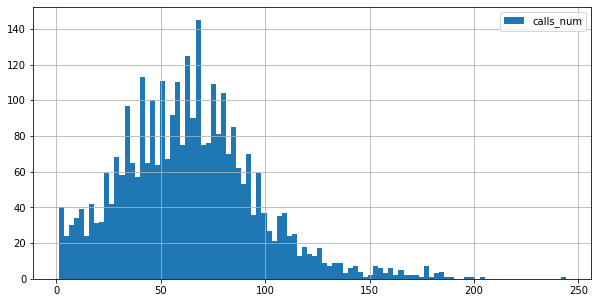

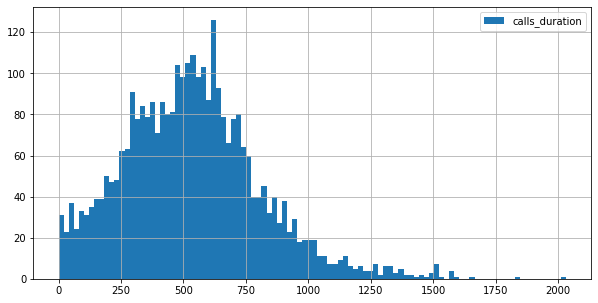

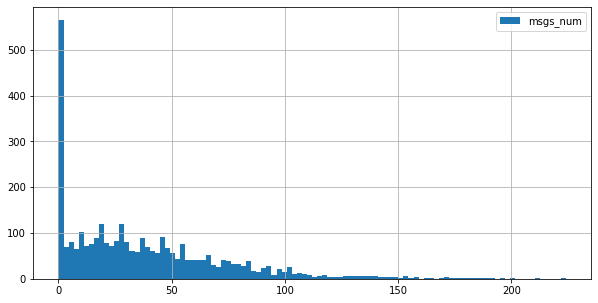

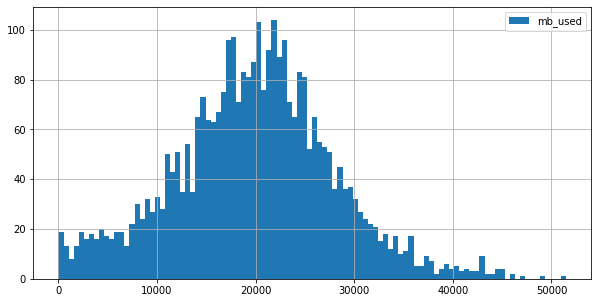

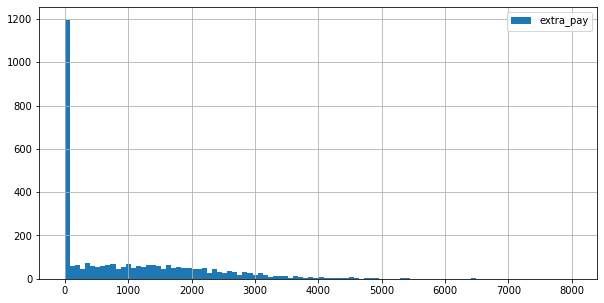

In [39]:
for feat in ['calls_num', 'calls_duration', 'msgs_num', 'mb_used', 'extra_pay']:
    total[feat].hist(bins=100, figsize=(10, 5), legend=feat)

    plt.show()

- большинство не доплачивает
- большинство не пользуется смс

## Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [40]:
total.groupby('tariff').rub_monthly_fee.mean()

tariff
smart     550
ultra    1950
Name: rub_monthly_fee, dtype: int64

выручка на смарте в 3.5 раза больше

- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

In [41]:
total = total.merge(users[['user_id', 'city']], on='user_id')

In [42]:
total[total.city == 'Москва'].rub_monthly_fee.mean()

1065.5482815057283

In [43]:
total[total.city != 'Москва'].rub_monthly_fee.mean()


958.7591240875912

москвичи платят больше на 10 процентов